# Projekt z przedmiotu Podstawy Reprezentacji i Analizy Danych

## Temat Projektu - Twitter

Projekt dotyczy zbioru danych z Twittera, zawierającego profile i przykładowe tweety użytkowników. Celem naszego projektu jest analiza podanego zbioru danych i próba przewidzenia płci (lub przynależności do firmy) użytkownika na jego podstawie.

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format

import re
import time
import collections

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to
[nltk_data]     /home/jakubkorczakowski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jakubkorczakowski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jakubkorczakowski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Opis zbioru danych

Zbiór danych składa się z kilkunastu kolumn z danymi. Są to:
1. __\_unit_id__: unikalne id użytkownika
2. __\_golden__: czy użytkownik znajduje się w złotym standardzie dla modelu; TRUE lub FALSE
3. __\_unit_state__: stan obserwacji
4. __\_trusted_judgments__: liczba potwierdzonych osądów
5. __\_last_judgment_at__: data i godzina ostatniego potwierdzonego osądu
6. __gender__: płeć lub przynależność do firmy, odpowiednio(male, female, lub brand (dla firm))
7. __gender\:confidence__: liczba rzeczywista z zakresu [0 , 1] odpowiadająca pewności osądu przynależności do płci lub firmy
8. __profile_yn__: informacja czy dany profil był dostępny do osądu
9. __profile_yn\:confidence__: pewność czy dany profil istnieje czy nie
10. __created__: data i czas utworzenia profilu
11. __description__: opis profilu użytkownika
12. __fav_number__: liczba twwetów, które użytkownik polubił
13. __gender_gold__: jaka jest płeć, jeżeli profil znajduje się w złotym standardzie
14. __link_color__: kolor linku w formacie hex
15. __name__: nazwa użytkownika
16. __profile_yn_gold__: czy pole __profile_yn__ należy do złotego standardu
17. __profileimage__: link do zdjęcia profilowego
18. __retweet_count__: ile razu użytkownik podał dalej tweeta
19. __sidebar_color__: kolor paska bocznego jako wartość hex
20. __text__: tekst jednego losowego tweetu użytkownika
21. __tweet_coord__: pozycja geograficzna użytkownika, jeśli była dostępna, w postaci "[szerokość geograficzna, długość geograficzna]"
22. __tweet_count__: liczba twwetów użytkownika
23. __tweet_created__: kiedy tweet z kolumny __text__ został utworzony
24. __tweet_id__: id losowego tweeta
25. __tweet_location__: lokalizacja tweeta
26. __user_timezone__: strefa czasowa użytkownika

## Wczytanie danych

Dane przechowywane są w pliku csv o nazwie __gender-classifier-DFE-791531.csv__. Za pomocą pakietu pandas wczytaliśmy je do naszego skryptu. Zdecydowaliśmy się na wybór kolumn 6,7, 11, 12, 14, 15, 18, 19, 20, 22, ponieważ inne kolumny zawierają informacje nieprzydatne dla naszego problemu.

In [125]:
df = pd.read_csv("../Data/gender-classifier-DFE-791531.csv", 
                 encoding = "latin1", 
                 engine='python', 
                 usecols=[5, 6, 10, 11, 13, 14, 17, 18, 19, 21])
df.head()

,gender,gender:confidence,description,fav_number,link_color,name,retweet_count,sidebar_color,text,tweet_count
0,male,1.00,i sing my own rhythm.,0,08C2C2,sheezy0,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964
1,male,1.00,I'm the author of novels filled with family dr...,68,0084B4,DavdBurnett,0,C0DEED,ÛÏIt felt like they were my friends and I was...,7471
2,male,0.66,louis whining and squealing and all,7696,ABB8C2,lwtprettylaugh,1,C0DEED,i absolutely adore when louis starts the songs...,5617
3,male,1.00,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,douggarland,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693
4,female,1.00,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,WilfordGemma,0,0,Watching Neighbours on Sky+ catching up with t...,31462


We wczytanym zbiorze danych znajduje się 20050 obiektów. Posiadają one 10 atrybutów, z których 6 jest typu `object`, 3 są typu `int64` i 1 typu `float64`. 

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 10 columns):
gender               19953 non-null object
gender:confidence    20024 non-null float64
description          16306 non-null object
fav_number           20050 non-null int64
link_color           20050 non-null object
name                 20050 non-null object
retweet_count        20050 non-null int64
sidebar_color        20050 non-null object
text                 20050 non-null object
tweet_count          20050 non-null int64
dtypes: float64(1), int64(3), object(6)
memory usage: 1.5+ MB


W zbiorze danych występują braki. Najwięcej wartości nieznanych jest w kolumnie `description`, która zawiera opis profilu użytkownika.

In [127]:
df.isna().sum(axis=0)

gender                 97
gender:confidence      26
description          3744
fav_number              0
link_color              0
name                    0
retweet_count           0
sidebar_color           0
text                    0
tweet_count             0
dtype: int64

## Czyszczenie danych

Kolumna `gender:confidence` zawiera pewność osądzenia płci użytkownika, przyjmuje ona wartości od 0 do 1. Do dalszej analizy usuniemy obiekty z pewnością mniejszą niż __0.9__ lub nieznaną, ze względu na ich małą wiarygodność.

In [128]:
df = df.where((df['gender:confidence'] > 0.9) & (df['gender'] != 'unknown')).dropna()
df.head()

,gender,gender:confidence,description,fav_number,link_color,name,retweet_count,sidebar_color,text,tweet_count
0,male,1.00,i sing my own rhythm.,0.00,08C2C2,sheezy0,0.00,FFFFFF,Robbie E Responds To Critics After Win Against...,110964.00
1,male,1.00,I'm the author of novels filled with family dr...,68.00,0084B4,DavdBurnett,0.00,C0DEED,ÛÏIt felt like they were my friends and I was...,7471.00
3,male,1.00,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202.00,0084B4,douggarland,0.00,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693.00
4,female,1.00,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318.00,3B94D9,WilfordGemma,0.00,0,Watching Neighbours on Sky+ catching up with t...,31462.00
5,female,1.00,you don't know me.,3901.00,F5ABB5,monroevicious,0.00,0,"Ive seen people on the train with lamps, chair...",20036.00


Po usunięciu wyżej wspomnianych obiektów w zbiorze danych pozostało 11779 wierszy. Nie ma w nich już braków.

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11779 entries, 0 to 20049
Data columns (total 10 columns):
gender               11779 non-null object
gender:confidence    11779 non-null float64
description          11779 non-null object
fav_number           11779 non-null float64
link_color           11779 non-null object
name                 11779 non-null object
retweet_count        11779 non-null float64
sidebar_color        11779 non-null object
text                 11779 non-null object
tweet_count          11779 non-null float64
dtypes: float64(4), object(6)
memory usage: 1012.3+ KB


Po wykonaniu redukcji można usunąć kolumnę `gender:confidence`, ponieważ nie będzie nam ona potrzebna w dalszej analizie.

In [130]:
df = df.drop(columns=['gender:confidence'])

## Przekształcenie kolumn zawierających kolory

W zbiorze danych są dwie kolumny zawierające informacje o kolorach. Są to: `link_color` oraz `sidebar_color`. Kolory są w nich zapisane heksadecymalnie. W celu użycia kolorów podczas klasyfikacji trzeba przekonwertować je do postaci RGB.

W kolumnach opisujących kolor występują wartości `9999` oraz `0`. Nie są one w formacie heksadecymalnym, więc należy je na niego zamienić.

In [131]:
df.link_color = df.link_color.replace(['9999', '0'], '000000')
df.sidebar_color = df.sidebar_color.replace(['9999', '0'], '000000')

Funkcja `hexToRGB` dokonuje konwersji liczby zapisanej w formacie heksadecymalnym na postać RGB.

In [132]:
def hexToRGB(color):
    if color == '0':
        return 255, 255, 255
    if len(color)<5:
        return 255, 255, 255
    try:
        color = color.replace(".", "")
        color = color.replace("+", "")
        r=int(color[0:2],16)
        g=int(color[2:4],16)
        b=int(color[4:6],16)
    except (RuntimeError, TypeError, NameError, ValueError):
        return None, None, None
    else:
        return r,g,b 

Dodanie kolumn z wartościami RGB kolorów w kolumnach `link_color` i `sidebar_color`.

In [133]:
df["link_color_R"] = df["link_color"].apply(lambda x: hexToRGB(str(x))[0])
df["link_color_G"] = df["link_color"].apply(lambda x: hexToRGB(str(x))[1])
df["link_color_B"] = df["link_color"].apply(lambda x: hexToRGB(str(x))[2])

df["sidebar_color_R"] = df["sidebar_color"].apply(lambda x: hexToRGB(str(x))[0])
df["sidebar_color_G"] = df["sidebar_color"].apply(lambda x: hexToRGB(str(x))[1])
df["sidebar_color_B"] = df["sidebar_color"].apply(lambda x: hexToRGB(str(x))[2])

df = df.dropna()
df.loc[:, ['link_color', 'sidebar_color', 'link_color_R', 'link_color_G', 'link_color_B', 'sidebar_color_R', 'sidebar_color_G', 'sidebar_color_B']].head()

,link_color,sidebar_color,link_color_R,link_color_G,link_color_B,sidebar_color_R,sidebar_color_G,sidebar_color_B
0,08C2C2,FFFFFF,8.00,194.00,194.00,255,255,255
1,0084B4,C0DEED,0.00,132.00,180.00,192,222,237
3,0084B4,C0DEED,0.00,132.00,180.00,192,222,237
4,3B94D9,000000,59.00,148.00,217.00,0,0,0
5,F5ABB5,000000,245.00,171.00,181.00,0,0,0


## Wykresy przedstawiające najczęściej używane kolory

Text(0.5, 1.0, 'Most used link colors by men')

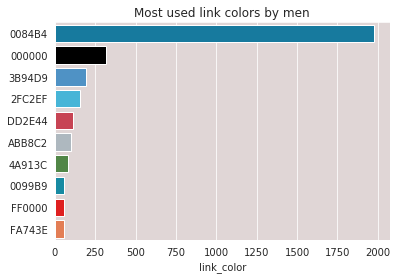

In [134]:
male_top_link_color = df[df['gender'] == 'male']['link_color'].value_counts().head(10)
male_top_link_color_idx = male_top_link_color.index
male_top_color = male_top_link_color_idx.values

l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
sns.barplot(x = male_top_link_color, y = male_top_color , palette=list(map(l, male_top_color))).set_title('Most used link colors by men')

Text(0.5, 1.0, 'Most used link colors by women')

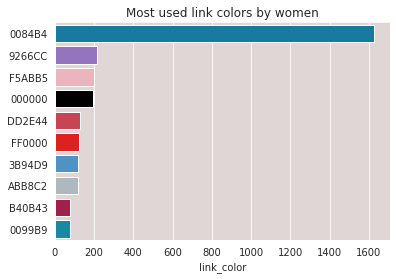

In [135]:
female_top_link_color = df[df['gender'] == 'female']['link_color'].value_counts().head(10)
female_top_link_color_idx = female_top_link_color.index
female_top_color = female_top_link_color_idx.values

l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
sns.barplot (x = female_top_link_color, y = female_top_color , palette=list(map(l, female_top_color))).set_title('Most used link colors by women')

Text(0.5, 1.0, 'Most used link colors by brands')

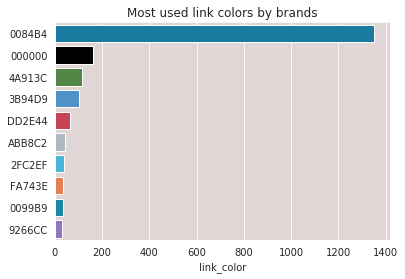

In [136]:
brand_top_link_color = df[df['gender'] == 'brand']['link_color'].value_counts().head(10)
brand_top_link_color_idx = brand_top_link_color.index
brand_top_color = brand_top_link_color_idx.values

l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
sns.barplot (x = brand_top_link_color, y = brand_top_color , palette=list(map(l, brand_top_color))).set_title('Most used link colors by brands')

Najczęściej wybieranym kolorem linku przez użytkowników Twittera jest kolor niebieski. W przypadku kolejnych kolorów kolejności występują różnicę. Drugim najczęściej wybieranym kolorem jest fioletowy dla kobiet, inny odcień niebieskiego dla mężczyzn oraz zielony dla firm. Ze względu na różnicę w wykresach, kolor linku jako atrybut może być przydatny.

Text(0.5, 1.0, 'Most used sidebar colors by men')

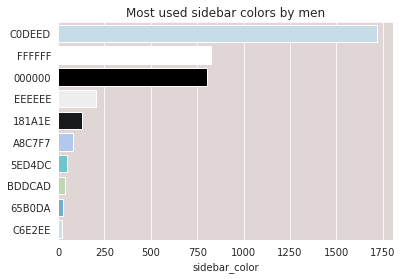

In [137]:
male_top_sidebar_color = df[df['gender'] == 'male']['sidebar_color'].value_counts().head(10)
male_top_sidebar_color_idx = male_top_sidebar_color.index
male_top_color = male_top_sidebar_color_idx.values

l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
sns.barplot (x = male_top_sidebar_color, y = male_top_color , palette=list(map(l, male_top_color))).set_title('Most used sidebar colors by men')

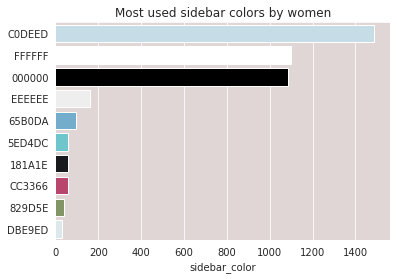

In [138]:
female_top_sidebar_color = df[df['gender'] == 'female']['sidebar_color'].value_counts().head(10)
female_top_sidebar_color_idx = female_top_sidebar_color.index
female_top_color = female_top_sidebar_color_idx.values

l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
plot4 =sns.barplot (x = female_top_sidebar_color, y = female_top_color, palette=list(map(l, female_top_color))).set_title('Most used sidebar colors by women')

Text(0.5, 1.0, 'Most used sidebar colors by brands')

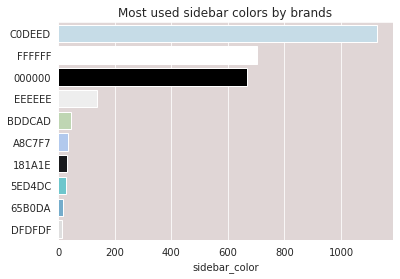

In [139]:
brand_top_sidebar_color = df[df['gender'] == 'brand']['sidebar_color'].value_counts().head(10)
brand_top_sidebar_color_idx = brand_top_sidebar_color.index
brand_top_color = brand_top_sidebar_color_idx.values

l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
sns.barplot (x = brand_top_sidebar_color, y = brand_top_color , palette=list(map(l, brand_top_color))).set_title('Most used sidebar colors by brands')

Cztery najczęściej używane kolory paska bocznego są takie same dla mężczyzn, kobiet i firm. Są to niebieski, biały, czarny i szary. Ze względu na brak różnic między grupami, kolor paska bocznego nie będzie atrybutem przydatnym podczas decydowania o przynależności do grup.

## Wykresy przedstawiające dane z atrybutów ilościowych

W zbiorze danych znajdują się 3 atrybuty ilościowe. Są to `fav_number`, `tweet_count`, `retweet_count`.

### Ilość polubień użytkownika

In [140]:
gfn_mean = (df.loc[:, ['gender', 'fav_number']]
            .groupby('gender')
            .mean()
            .sort_values(by='fav_number'))
gfn_mean

,fav_number
gender,
brand,2009.19
male,4801.83
female,6369.06


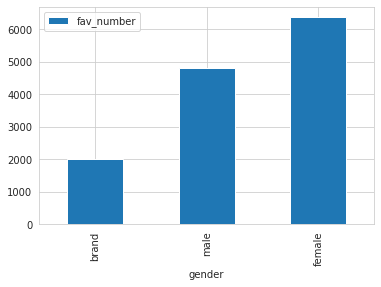

In [141]:
sns.set_style("whitegrid", {"axes.facecolor": "#FFFFFF"})
gfn_mean.plot.bar()

### Ilość tweetów użytkownika

In [142]:
gtc_mean = (df.loc[:, ['gender', 'tweet_count']]
            .groupby('gender')
            .mean()
            .sort_values(by='tweet_count'))
gtc_mean

,tweet_count
gender,
female,26065.72
male,31268.01
brand,70313.51


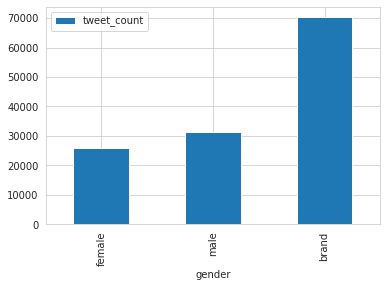

In [143]:
gtc_mean.plot.bar()

### Ilość razy kiedy użytkownik podał tweet dalej

In [144]:
grc_mean = (df.loc[:, ['gender', 'retweet_count']]
            .groupby('gender')
            .mean()
            .sort_values(by='retweet_count'))
grc_mean

,retweet_count
gender,
female,0.03
brand,0.09
male,0.12


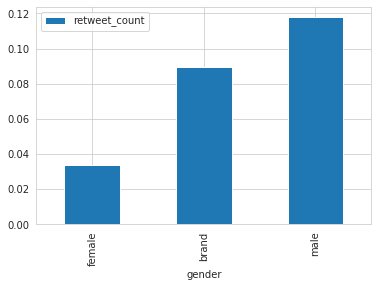

In [145]:
grc_mean.plot.bar()

## Przekształcanie kolumn zawierających tekst

### Usuwanie znaków specjalnych z tekstu i opisu

Funckja usuwająca znaki spoza systemu ASCII, linki, znaki specjalne oraz podwójne spacje.

In [146]:
def normalize_text(text):
    text = text.lower()
    
    # Usuń znaki spoza ASCII
    text = re.sub('[^\x00-\x7F]+',' ', text)
    
    # Usuń linki
    text = re.sub('https?:\/\/.*[\r\n] ', ' ', text)
    
    # Usuń znaki specjalne
    text = re.sub('[?!+%{}:;.,#"\'()\[\]_#\&-@]', '',text) #@&-
    
    # Usuń podwójne spacje
    text = re.sub('\s+',' ',text)
    
    return text

W orginalnej tabeli zostają stworzone trzy dodatkowe kolumny. Jedna `tekst_norm` jest znormalizowanym tekstem tweeta, druga `description_norm` jest znormalizowanym opisem oraz trzecia `all_text` jest połączeniem znormalizowanych tekstu i opisu.

In [147]:
df['text_norm'] = [normalize_text(text) for text in df['text']]
df['description_norm'] = [normalize_text(text) for text in df['description']]
df['all_text'] = df['text_norm'].str.cat(df['description_norm'],sep=' ')

df = df.reset_index(drop=True)

### Stop words

Zbiór słów nazywany __stop words__ zawiera słowa nieposiadające dużego znaczenia. Usuwa się je w celu oczyszczenia danych tekstowych.

In [148]:
def del_stop_words_from_text(text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 
    
    w_text = ""
  
    for w in word_tokens: 
        if w not in stop_words: 
            w_text += w
            w_text += " "
    
    return w_text

In [149]:
df['text_stop'] = [del_stop_words_from_text(text) for text in df['text_norm']]
df['all_text_stop'] = [del_stop_words_from_text(text) for text in df['all_text']]
df['description_stop'] = [del_stop_words_from_text(text) for text in df['description_norm']]

Przykładowe tweety przed i po usunięciu __stop words__.

In [150]:
df['text_norm'][3]

'watching neighbours on sky catching up with the neighbs xxx xxx'

In [151]:
df['text_stop'][3]

'watching neighbours sky catching neighbs xxx xxx '

### Stemming

__Stemming__ to technika normalizacji danych tekstowych polegająca usunięciu końcówek z wyrazów.

In [152]:
def stem_text(text, stemmer):
    text_list = text.split()
    
    s_text = ""
    
    for item in text_list:
        s_text += stemmer.stem(item)
        s_text += " "
    
    return s_text

In [153]:
stemmer = SnowballStemmer("english")

df['text_stem'] = [stem_text(text, stemmer) for text in df['text_stop']]
df['all_text_stem'] = [stem_text(text, stemmer) for text in df['all_text_stop']]
df['description_stem'] = [stem_text(text, stemmer) for text in df['description_stop']]

Przykładowe tweety przed i po zastosowaniu techniki __stemming__.

In [154]:
df['text_stop'][3]

'watching neighbours sky catching neighbs xxx xxx '

In [155]:
df['text_stem'][3]

'watch neighbour sky catch neighb xxx xxx '

## Wizualizacja najczęściej używanych słów ze względu na płeć

Funckja tworząca wykresy najczęściej użytych słów dla płci oraz dla wybranego tekstu. 

In [156]:
def plot_common_words(gender, text_name, color):
    X = df[df['gender'] == gender][[text_name]]
    X.columns=['Text']
    text = X['Text'].tolist()

    tokens = []

    for item in text:
        tokens.append(word_tokenize(item))

    words = []

    for item in tokens:
        words = words + item

    counter = dict(collections.Counter(words))
    counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index().rename(columns={'index':'word', 0:'count'})
    counter_df = counter_df.sort_values(by=['count'], ascending=False).head(10)
    
    plt.figure(figsize=(14, 7))
    plt.barh(counter_df['word'], counter_df['count'], color=color)
    plt.title('Most used words by ' + gender + 's for ' + text_name)
    plt.xlabel('frequency')
    plt.ylabel('words')
    plt.gca().invert_yaxis()
    plt.show()

Użycie funkcji, dla wszystkich płci, dla połączonego tekstu tweeta i opisu.

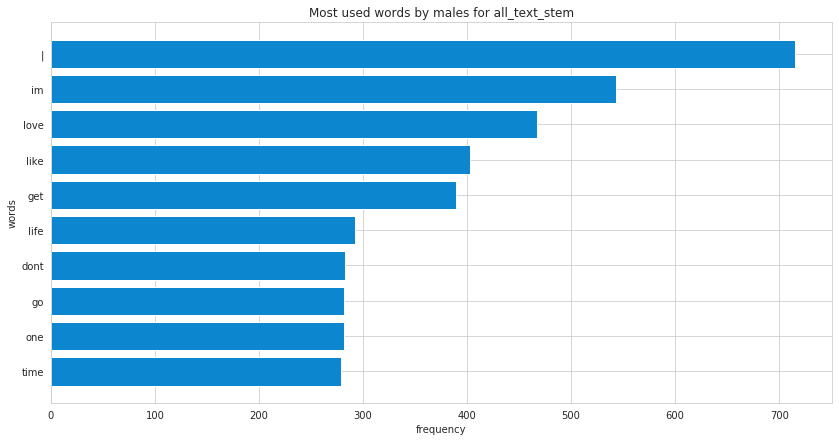

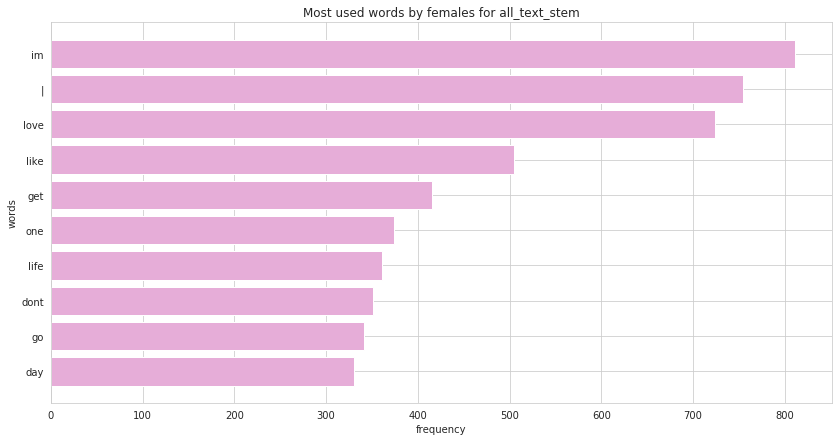

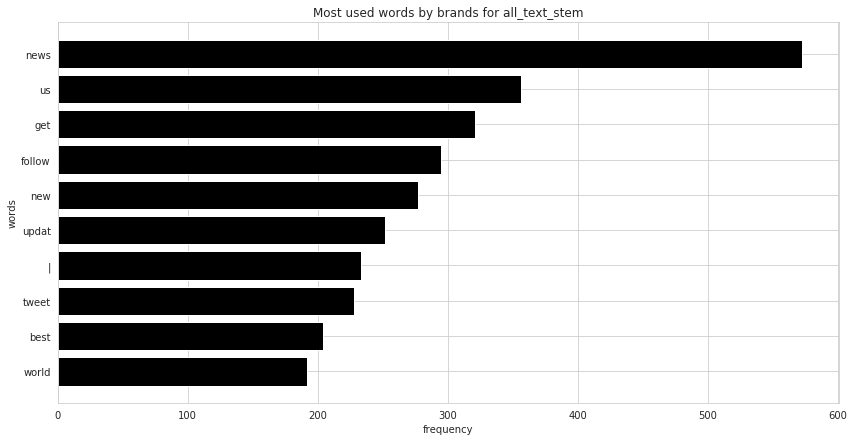

In [157]:
# cały tekst
plot_common_words('male', 'all_text_stem', '#0C86CF')
plot_common_words('female', 'all_text_stem', '#E6ADD8')
plot_common_words('brand', 'all_text_stem', '#000000')

W połączonym tekście widać wyraźnie różnicę w słowach używanych przez firmy i przez osoby prywatne. Niestety różnica między słowami używanymi przez mężczyzn i kobiety.

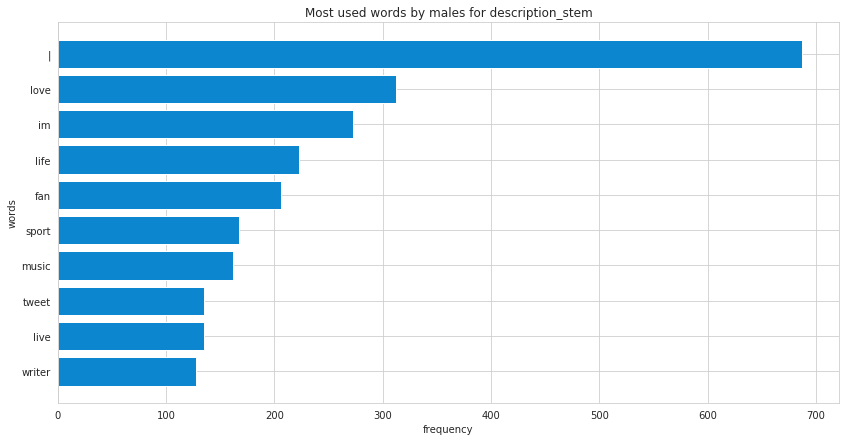

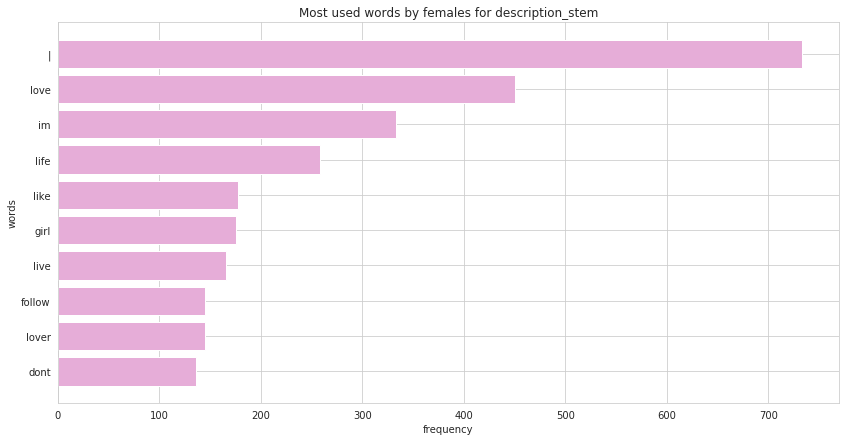

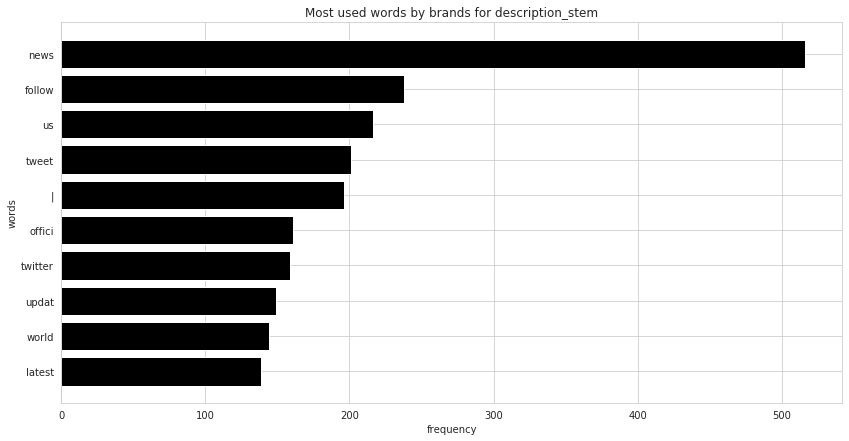

In [158]:
# opis
plot_common_words('male', 'description_stem', '#0C86CF')
plot_common_words('female', 'description_stem', '#E6ADD8')
plot_common_words('brand', 'description_stem', '#000000')

W opisie profilu ponownie można wyraźnie odróżnić słowa używane przez firmy. W przypadku obu płci pokrywają się pierwsze 4 pozycje na liście, jednak kolejne słowa różnią się od siebie.

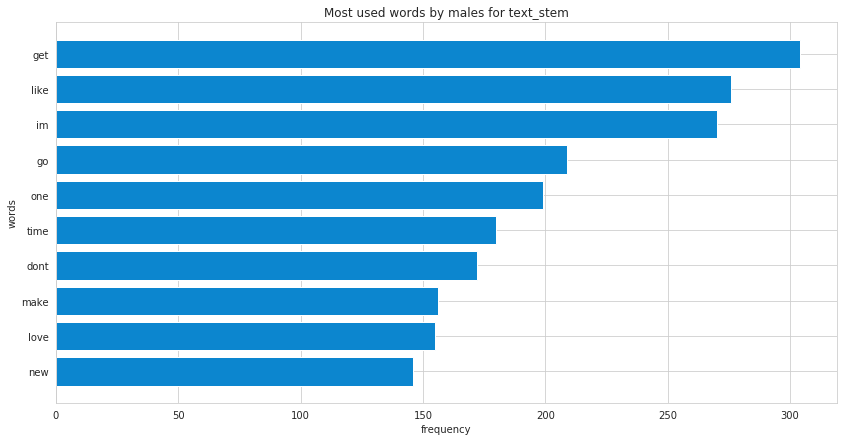

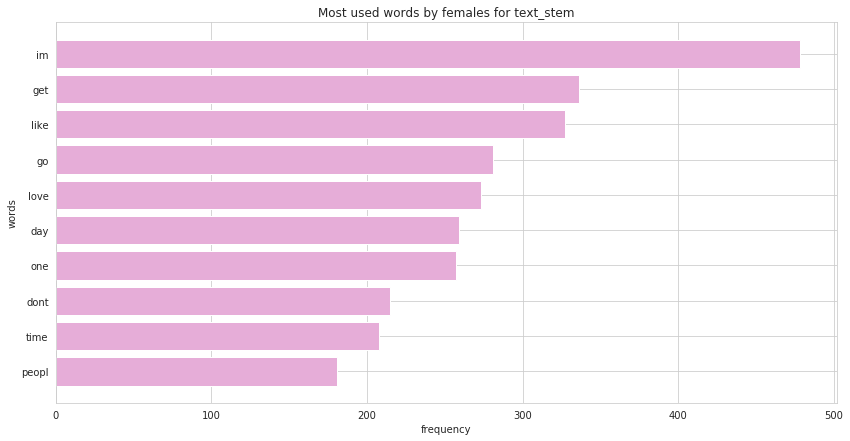

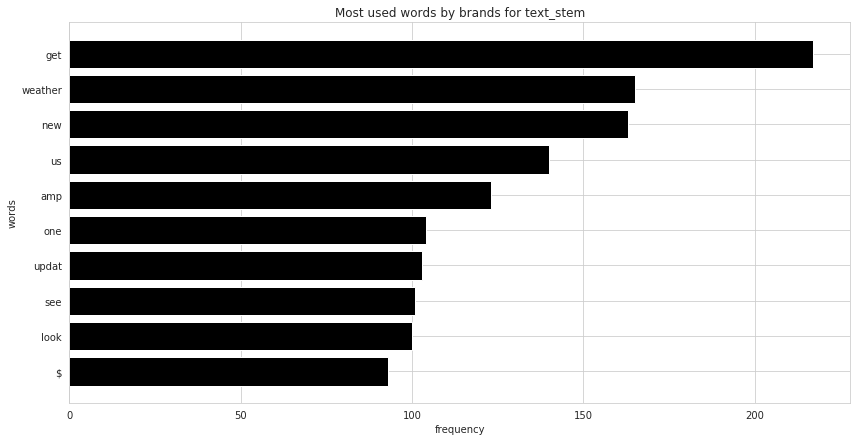

In [159]:
# tekst tweeta
plot_common_words('male', 'text_stem', '#0C86CF')
plot_common_words('female', 'text_stem', '#E6ADD8')
plot_common_words('brand', 'text_stem', '#000000')

W tekscie tweeta sytuacja jest podobna jak w przypadku całego tekstu i opisu.

# Przewidywanie płci

## Wybór klasyfikatora

Postanowiliśmy sprawdzić działanie trzech klasyfikatorów: `MultinomialNB`, `KNeighborsClassifier` i `RandomForestClassifier`, czyli odpowiednio naiwnego klasyfikatora bayesowskiego, klasyfikatora k-najbliższych sąsiadów oraz klasyfikatora wykorzystującego drzewa decyzyjne.

Funkcja wykorzystująca podany klasyfikator, przewidująca jakiej płci jest użytkownik, na podstawie wybranego tekstu.

In [161]:
def predict_for_set(data_set, text, clf):
    X = data_set[[text]]
    y = data_set[['gender']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    count_vect = CountVectorizer()
    X_train_vect = count_vect.fit_transform(X_train.iloc[:, 0])
    X_test_vect = count_vect.transform(X_test.iloc[:, 0])

    
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_vect)
    X_test_tfidf = tfidf_transformer.fit_transform(X_test_vect)

    t_start=time.time()
    
    alg = clf.fit(X_train_tfidf, y_train)

    t_pred = round(time.time() - t_start, 3)
    
    y_pred = alg.predict(X_test_tfidf)
    
    y_pred_tr = alg.predict(X_train_tfidf)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    return accuracy, t_pred

Porównanie klasyfikatorów i różnych tekstów.

In [162]:
clf_m = MultinomialNB()
clf_k = KNeighborsClassifier()
clf_r = RandomForestClassifier()

clf_list = [clf_m, 
            clf_k, 
            clf_r]

clf_names_list = ['MultinomialNB', 
                  'KNeighborsClassifier', 
                  'RandomForestClassifier']

texts_list = ['text_norm', 
              'description_norm', 
              'all_text']

data = {'Klasyfikator':[], 
        'Kolumna z tekstem':[], 
        'Dokładność':[], 
        'Czas':[]}

for i in range(len(clf_list)):
    for text_name in texts_list:
        res = predict_for_set(df, text_name, clf_list[i])
        data['Klasyfikator'].append(clf_names_list[i])
        data['Kolumna z tekstem'].append(text_name)
        data['Dokładność'].append(res[0])
        data['Czas'].append(res[1])
        
clf_df = pd.DataFrame(data=data)
clf_df

/home/jakubkorczakowski/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jakubkorczakowski/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jakubkorczakowski/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jakubkorczakowski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1

,Klasyfikator,Kolumna z tekstem,Dokładność,Czas
0,MultinomialNB,text_norm,0.49,0.02
1,MultinomialNB,description_norm,0.67,0.02
2,MultinomialNB,all_text,0.62,0.02
3,KNeighborsClassifier,text_norm,0.50,0.01
4,KNeighborsClassifier,description_norm,0.45,0.01
5,KNeighborsClassifier,all_text,0.56,0.01
6,RandomForestClassifier,text_norm,0.48,1.24
7,RandomForestClassifier,description_norm,0.60,1.06
8,RandomForestClassifier,all_text,0.56,1.15


Wykres przedstawiający dokładność i czas trenowania w zależności od wybranego klasyfikatora i tekstu.

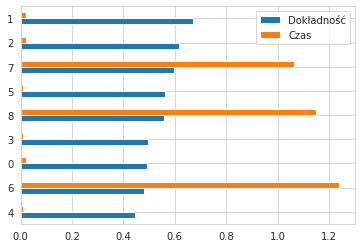

In [163]:
clf_df.sort_values(by='Dokładność').plot.barh()

Na podstawnie wykresu widać, że najlepsze efekty daje klasyfikator `MultinomialNB` z wykorzystaniem kolumny `description_norm`, czyli samego opisu.	

In [164]:
def predict_for_set_and_draw(data_set, text, clf):
    X = data_set[[text]]
    y = data_set[['gender']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    count_vect = CountVectorizer()
    X_train_vect = count_vect.fit_transform(X_train.iloc[:, 0])
    X_test_vect = count_vect.transform(X_test.iloc[:, 0])

    
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_vect)
    X_test_tfidf = tfidf_transformer.fit_transform(X_test_vect)
    
    alg = clf.fit(X_train_tfidf, y_train)
    
    y_pred = alg.predict(X_test_tfidf)
    
    y_pred_tr = alg.predict(X_train_tfidf)
    
    print("Accuracy dla zbioru testowego: ")
    print(metrics.accuracy_score(y_test, y_pred), "\n")
    print("Accuracy dla zbioru uczącego: ")
    print(metrics.accuracy_score(y_train, y_pred_tr), "\n")
    
    #print("Macierz pomyłek dla zbioru uczącego")
    #print(pd.crosstab(y_train.to_numpy().transpose()[0], y_pred_tr)) 
    #sns.heatmap(pd.crosstab(y_train.to_numpy().transpose()[0], y_pred_tr),
    #        cmap="YlGnBu", annot=True, cbar=False)
    
    print("Macierz pomyłek dla zbioru testowego")
    print(pd.crosstab(y_test.to_numpy().transpose()[0], y_pred)) 
    sns.heatmap(pd.crosstab(y_test.to_numpy().transpose()[0], y_pred),
            cmap="YlGnBu", annot=True, cbar=False)

Przewidywanie płci na podstawie opisu

Accuracy dla zbioru testowego: 
0.6918505942275043 

Accuracy dla zbioru uczącego: 
0.8924856718318829 

Macierz pomyłek dla zbioru testowego
col_0   brand  female  male
row_0                      
brand     442      80    48
female     33     758   201
male       41     323   430


/home/jakubkorczakowski/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


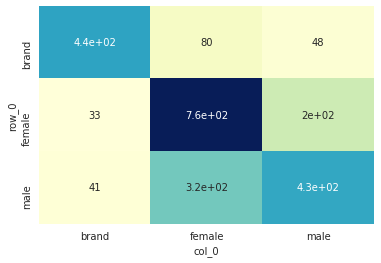

In [165]:
predict_for_set_and_draw(df, 'description_norm', clf_m)

Na podstawnie macierzy pomyłek widać, że klasyfikator poprawnie rozpoznaje firmy, problem ma z rozróżnieniem kobiet i mężczyzn.

## Podsumowanie

Problemem postawionym podczas tego projektu było rozpoznawanie płci użytkowników Twittera. Udało nam się rozpoznawać płeć z dokładnością około __67%__. Wynik ten mógłbybyć poprawiony prawdopodocnie poprzez dodanie większej ilości atrybutów lub zastosowanie bardziej złożonych obliczeniowo algorytmów.